In [1]:
import pandas as pd
import os

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

---

# Load data

In [5]:
pwd

'/Users/braulio/Documents/github/FAKE'

In [6]:
CORPUS = []
LABEL = []

In [7]:
# Step 1: get all the fake news text files into a list named corpus, give them label 1 -- fake
dir1 = 'Data/size_normalized_texts/fake/'
list = os.listdir(dir1)
number_files = len(list)

In [8]:
for i in range(number_files):
        title = list[i]
        LABEL.append(1)
        with open(dir1 + title,'r') as reader:

            doc = reader.read()
            doc.lower()
            doc.split()
            reader.close
            CORPUS.append(doc)

In [9]:
assert len(CORPUS) == len(LABEL)

In [10]:
len(CORPUS)

3600

In [11]:
# Step 2: repeat the procedure with true news, give them label 0 -- true

In [12]:
dir2 = 'Data/size_normalized_texts/true/'
list = os.listdir(dir2)
number_files = len(list)

In [13]:
for i in range(number_files):
        title = list[i]
        LABEL.append(0)
        with open(dir2 + title,'r') as reader:

            doc = reader.read()
            doc.lower()
            doc.split()
            reader.close
            CORPUS.append(doc)

In [14]:
assert len(CORPUS) == len(LABEL)

# Vectorize words

In [15]:
def vectors_and_df(corpus, label):
    """creates vectors for songs and returns dataframe with songs as word vectors 
    by all artists"""
    
    cv = TfidfVectorizer()
    cv.fit(corpus)
    corpus_vecs = cv.transform(corpus)
    
    return pd.DataFrame(corpus_vecs.todense(), index=label, 
                        columns=cv.get_feature_names()), cv

In [16]:
# Store results into dataframe, keep cv for later prediction
df, cv = vectors_and_df(CORPUS, LABEL)

# Split and train data

In [17]:
# Define features and target column
X = df
y = df.index

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

## Try different models

In [19]:
MODELS = {
    "MultinomialNB": {"alpha": 0.005},
    "CategoricalNB": {"alpha": 0.01},
    "RandomForestClassifier": {
        "n_estimators": 500,
        "max_depth": 200,
        "max_features": "auto",
        "n_jobs": -1,
        "random_state": 1,
    },
    "LogisticRegression": {"C": 1e6},
}

def train_models(models_params):
    """trains models on corpus and returns dataframe with scores"""
    
    scores = {}
    for model in models_params:
        if model == "LogisticRegression":
            m = LogisticRegression(**models_params[model])
        elif model == "RandomForestClassifier":
            m = RandomForestClassifier(**models_params[model])
        elif model == "MultinomialNB":
            m = MultinomialNB(**models_params[model])
        elif model == "CategoricalNB":
            m = MultinomialNB(**models_params[model])

        m.fit(Xtrain, ytrain)
        score_train = m.score(Xtrain, ytrain)
        score_test = m.score(Xtest, ytest)
        scores[f"{model}"] = {
            "params": models_params[model],
            "train score": score_train,
            "test score": score_test,
            }
    return pd.DataFrame(scores).T

In [20]:
train_models(MODELS)

,params,train score,test score
MultinomialNB,{'alpha': 0.005},0.988715,0.849306
CategoricalNB,{'alpha': 0.01},0.987153,0.85
RandomForestClassifier,"{'n_estimators': 500, 'max_depth': 200, 'max_f...",1,0.886111
LogisticRegression,{'C': 1000000.0},1,0.934722


In [46]:
# Evaluate model
model = "LogisticRegression"
m = LogisticRegression(**MODELS[model], max_iter=200)
m.fit(Xtrain, ytrain)

LogisticRegression(C=1000000.0, max_iter=200)

In [47]:
# Create the predictions for Y training data
preds = m.predict(Xtest)

print(m.score(Xtest, ytest))

0.9347222222222222


In [48]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [49]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(ytest, preds)
cnf_matrix

array([[685,  52],
       [ 42, 661]])

Text(0.5, 257.44, 'Predicted label')

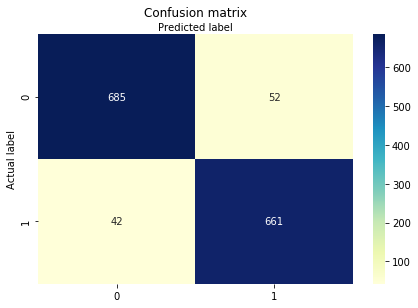

In [53]:
# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [51]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [52]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(ytest, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(ytest, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(ytest, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 93.47 %
Precision: 92.71 %
Recall: 94.03 %
Specificity: 92.94 %
Misclassification Rate: 6.42 %


# Train the entire dataset on best perfoming model

In [ ]:
model = "LogisticRegression"
m = LogisticRegression(**MODELS[model], max_iter=200)
m.fit(X, y)

# Create prediction function

In [22]:
def predict(new_text):
    
    """
    Takes the pre-trained model pipeline and predicts new artist based on unseen text.
    
    Parameters
    ----------
    model : Trained scikit-learn model pipeline.
    new_text : str
    
    Returns
    ---------
    prediction : str
    
    """
    article = [new_text]
    # transform song into vector matrix
    new_article_vecs = cv.transform(article)
    ynew = new_article_vecs.todense()
    
    prediction = m.predict(ynew)
    
    return prediction[0]

In [23]:
if __name__ == '__main__':
    # Whatever happens after this line, execute it when running "python lyrics_classifier.py"
    # and DO NOT execute these lines of code if things from this script are imported from other scripts.
    
    user_input = input('Please Enter Some Text: ')

    prediction = predict(user_input)
    print('Here is your prediction!')
    print(prediction)

Please Enter Some Text: Mensagem de Robert F. Kennedy, Jr. "Para todos os meus pacientes: Gostaria de chamar sua atenção com urgência para questões importantes relacionadas à próxima vacinação contra Covid-19. Pela primeira vez na história da vacinação, as chamadas vacinas de mRNA de última geração intervêm diretamente no material genético do paciente e, portanto, alteram o material genético individual, que representa a manipulação genética, algo que já foi proibido e até então considerado criminoso. Essa intervenção pode ser comparada à de alimentos geneticamente manipulados, que também é altamente controversa. Mesmo que a mídia e os políticos atualmente banalizem o problema e até mesmo clamem estupidamente por um novo tipo de vacina para voltar à normalidade, essa vacinação é problemática em termos de saúde, moral e ética, e também em termos de danos genéticos que, ao contrário dos danos causados pelas vacinas anteriores, serão irreversíveis e irreparáveis. Caros pacientes, após uma 